# Fitting PRFs in K2 Campaign 11.1

In [1]:
%matplotlib inline
from astropy.io import fits as pyfits
import tqdm
import numpy as np
import matplotlib.pyplot as pl
from pyke import KeplerTargetPixelFile, KeplerQualityFlags
import photutils.aperture as apr
from oktopus import PoissonLikelihood
from pyke.kepler_prf import KeplerPRF

/Users/jvmirca/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [22]:
from matplotlib import rc
rc('text', usetex=True)
font = {'family' : 'serif',
        'size'   : 18,
        'serif'  : 'New Century Schoolbook'}
rc('font', **font)

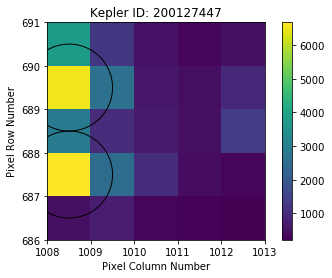

In [2]:
tpf = KeplerTargetPixelFile('ktwo200127447-c111_lpd-targ.fits.gz',
                            quality_bitmask=KeplerQualityFlags.QUALITY_ZERO_BITMASK)
bkg = tpf.estimate_background(method='median')
apr.CircularAperture((1008.5, 687.5), r=1).plot()
apr.CircularAperture((1008.5, 689.5), r=1).plot()
tpf.plot(scale='linear')

In [3]:
lc1, lc2, lc3 = np.zeros(len(tpf.time)), np.zeros(len(tpf.time)), np.zeros(len(tpf.time))
for i in range(len(tpf.time)):
    lc1[i] = apr.CircularAperture((1008.5 - tpf.column, 687.5 - tpf.row), r=1).do_photometry(tpf.flux[i])[0]
    lc2[i] = apr.CircularAperture((1008.5 - tpf.column, 689.5 - tpf.row), r=1).do_photometry(tpf.flux[i])[0]

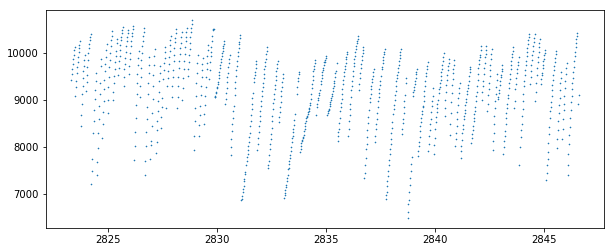

In [4]:
pl.figure(figsize=[10, 4])
pl.plot(tpf.time, lc1, 'x', markersize=1)

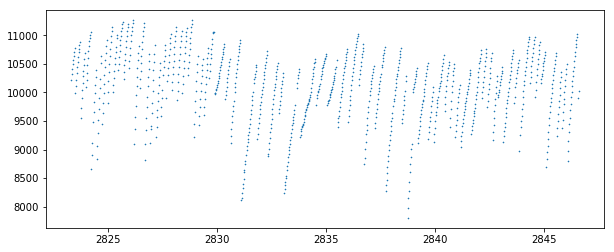

In [5]:
pl.figure(figsize=[10, 4])
pl.plot(tpf.time, lc2, 'x', markersize=1)

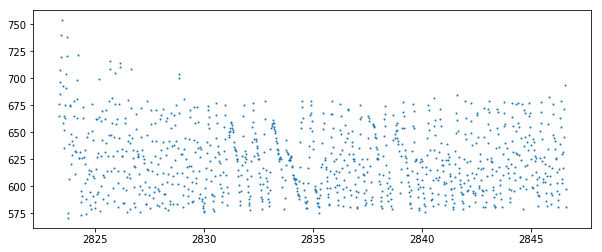

In [6]:
pl.figure(figsize=[10, 4])
pl.plot(tpf.time, bkg, 'o', markersize=1)

In [7]:
xc1_hat, xc2_hat = [], []
yc1_hat, yc2_hat = [], []
f1_hat, f2_hat = [], []
bkg_hat = []
residuals = []
loglike = []
prf1, prf2 = [], []
best_fit_params = []
kepprf = KeplerPRF(tpf.channel, (tpf.shape[1], tpf.shape[2]),
                   tpf.column, tpf.row,
                   prf_files_dir="/Users/jvmirca/.pyke/kepler-prf-calibration-data/")
for i in tqdm.tqdm(range(len(tpf.time))):
    x0 = (lc1[i] - 12.5 * bkg[i],
          lc2[i] - 12.5 * bkg[i],
          1008.5, 1008.5,
          687.5, 689.5,
          bkg[i])
    logL = PoissonLikelihood(tpf.flux[i], kepprf.evaluate)
    result = logL.fit(x0, method='Powell', options={'xtol':1e-10, 'ftol':1e-10})
    best_fit_params = np.append(best_fit_params, result.x)
    loglike = np.append(loglike, logL.evaluate(result.x))
    f1_hat = np.append(f1_hat, result.x[0])
    f2_hat = np.append(f2_hat, result.x[1])
    xc1_hat = np.append(xc1_hat, result.x[2])
    xc2_hat = np.append(xc2_hat, result.x[3])
    yc1_hat = np.append(yc1_hat, result.x[4])
    yc2_hat = np.append(yc2_hat, result.x[5])
    bkg_hat = np.append(bkg_hat, result.x[6])
    prf1 = np.append(prf1, kepprf.prf_model[0])
    prf2 = np.append(prf2, kepprf.prf_model[1])
    residuals = np.append(residuals, tpf.flux[i] - kepprf.evaluate(*result.x))

 66%|██████▌   | 681/1038 [07:35<04:58,  1.19it/s]/Users/jvmirca/anaconda3/lib/python3.6/site-packages/autograd/core.py:82: RuntimeWarning: invalid value encountered in log
  result_value = self.fun(*argvals, **kwargs)
100%|██████████| 1038/1038 [13:04<00:00,  1.23s/it]


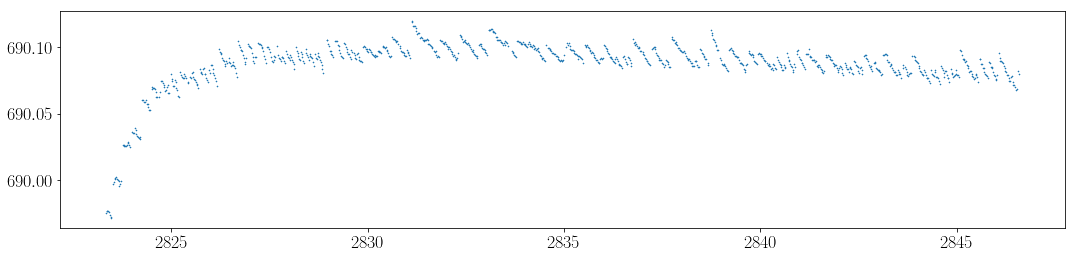

In [23]:
pl.figure(figsize=[18, 4])
pl.plot(tpf.time, yc2_hat, 'x', markersize=1)

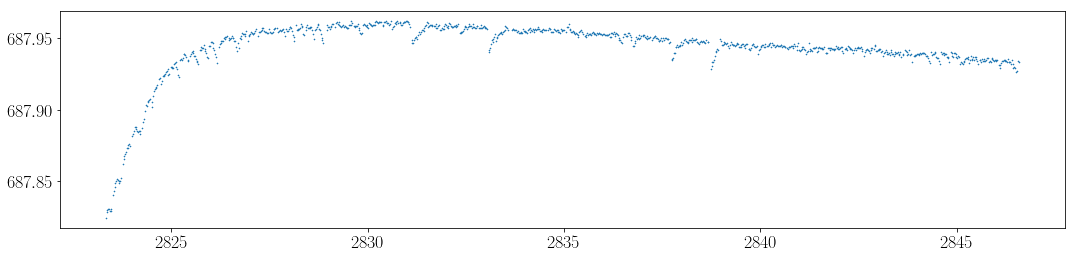

In [24]:
pl.figure(figsize=[18, 4])
pl.plot(tpf.time, yc1_hat, 'x', markersize=1)

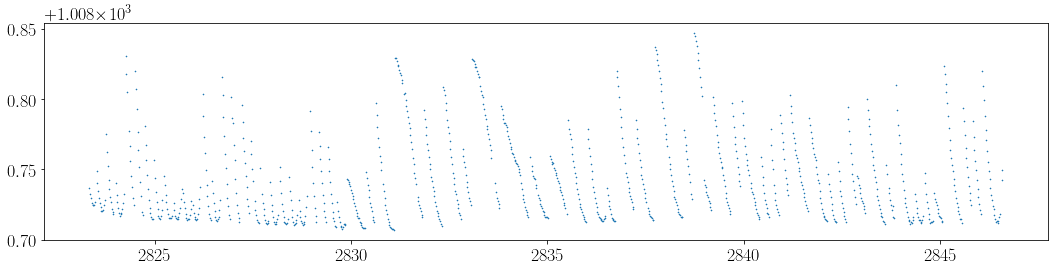

In [25]:
pl.figure(figsize=[18, 4])
pl.plot(tpf.time, xc1_hat, 'x', markersize=1)

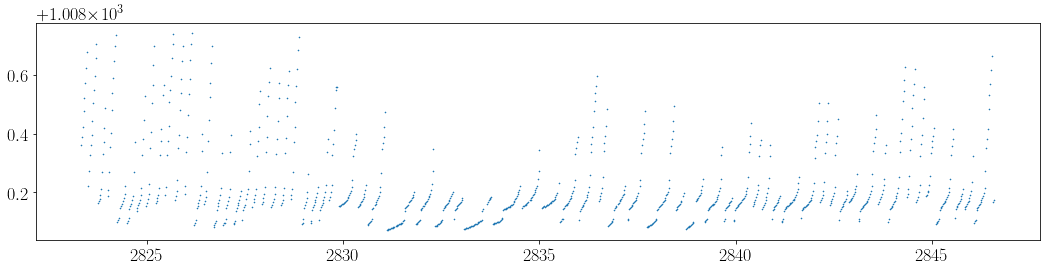

In [26]:
pl.figure(figsize=[18, 4])
pl.plot(tpf.time, xc2_hat, 'x', markersize=1)

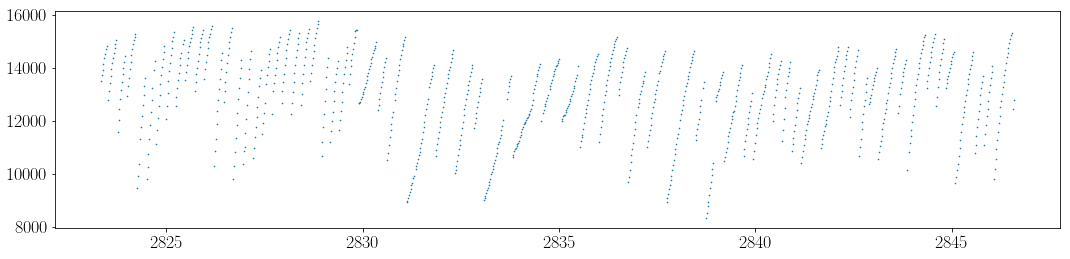

In [27]:
pl.figure(figsize=[18, 4])
pl.plot(tpf.time, f1_hat, 'x', markersize=1)

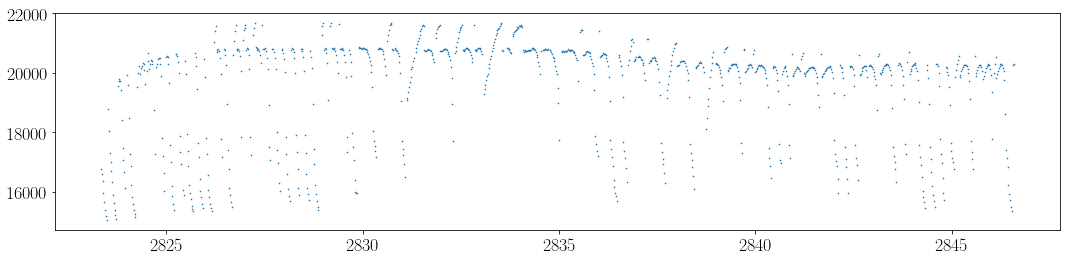

In [28]:
pl.figure(figsize=[18, 4])
pl.plot(tpf.time, f2_hat, 'x', markersize=1)

In [14]:
residuals = residuals.reshape(tpf.shape)
fitted_prf = kepprf.evaluate

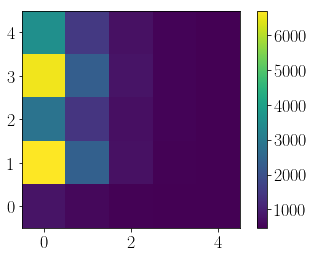

In [29]:
i = 100
pl.imshow(fitted_prf(f1_hat[i], f2_hat[i], xc1_hat[i], xc2_hat[i], yc1_hat[i], yc2_hat[i], bkg_hat[i]),
           origin='lower')
pl.colorbar()

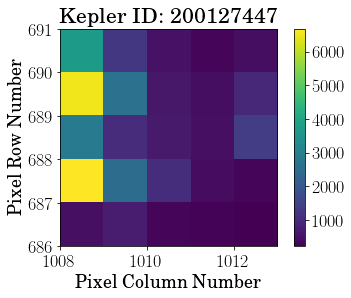

In [30]:
tpf.plot(nframe=100, scale='linear')

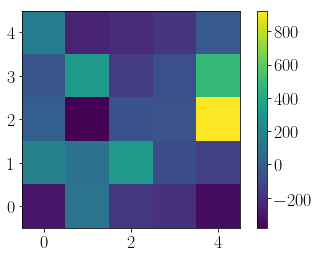

In [31]:
pl.imshow(residuals[i], origin='lower')
pl.colorbar()

In [18]:
prf1 = np.array(prf1).reshape(tpf.shape)
prf2 = np.array(prf2).reshape(tpf.shape)

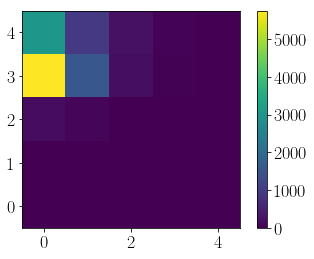

In [32]:
pl.imshow(prf2[i], origin='lower')
pl.colorbar()

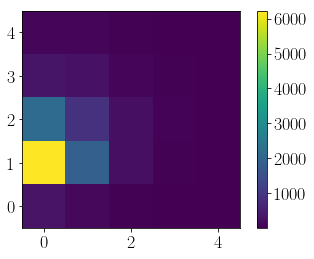

In [33]:
pl.imshow(prf1[i], origin='lower')
pl.colorbar()